# VU AI Winter School: Introduction to Psychiatry Use Case

## Background

Psychiatry aims to prevent individuals from developing mental disorders and to provide cost-effective treatment when they do. These practical goals are pursued by combining theoretical and methodogical insights from different disciplines, ranging from neuroscience to artificial intelligence (AI). Although AI has been around for decades now and is massively popular with highly useful, openly available tools such as ChatGPT, its application in psychiatry is relatively new and much interesting work is probably yet to come. Needless to say, we hope the groundwork for some of this interesting work will be produced during this VU AI Winter School! 

## Data challenge

In the next few days, you will have a unique opportunity to apply AI methodologies to build a smartphone/watch-based technology that might someday help psychiatry to pursue its main objectives. We have kept this challenge relatively open-ended because we do not want to give you the impression that there is One Use Case To Rule Them All. Instead, from an AI perspective, we believe the data we provide here has the potential to be used for developing tools with (somewhat or quite) different use cases. Throughout this notebook, we will give hints for potential use cases here and there, but these are not intended to be exhaustive and we encourage you to work on your own idea if you have one and feel comfortable enough to implement it. 

## Data overview

If you have signed our NDA (to fully protect the privacy of our participants), we will provide you with the following (anonymized) datasets which were taken from the Netherlands Study of Depression and Anxiety (NESDA):
- diagnostic status data
- disorder severity data
- minute-by-minute actigraphy data 
- experience sampling data 

<b>Diagnostic status ('diagnostic-status-obfuscated.csv')</b>

NESDA participants were interviewed with the gold-standard Clinical International Diagnostic Interview (CIDI) to determine if they had met criteria for a depression and/or anxiety disorder in the past 6 months. For these individuals, we also know - based on their previous NESDA interviews - if they met diagnostic criteria for one of these disorders in the past. We provide this information in the first dataset which contains an ID column as well as three disorder columns. These columns indicate if a person has a current disorder (1 = diagnosis in the past 6 months; 0 is no diagnostis in the past 6 months), has a remitted disorder (1 = had a diagnosis at one point in their life but not in the past 6 months; 0 = disorder in the past 6 months/never had one), or does not have a history of disorder (1 = never had a disorder, 0 = either has a disorder now or had one at some point in their life). These can be combined into a single column (with three categories) but it might be easier to work with one of these columns first.

<b>Disorder severity ('disorder-severity-obfuscated.csv')</b>

Alongside diagnostic status of these individuals, we also provide data on the total self-reported severity of depression (Inventory of Depression Symptomatology; IDS) and anxiety (Beck Anxiety Inventory; BAI). This dataset provides complementary information to the previous one and allows you to look at depression and anxiety separately. This info can also be combined with the diagnostic status data. Again, it might be easiest to work with a single column first, although using both might be very interesting as well. Note: We added normally distributed noise to the original values to add an additional layer of data anonimization. We take the privacy of our participants seriously!

<b>Minute-by-minute actigraphy ('actigraphy-obfuscated.csv')</b>

Our most challenging dataset comes from wrist-worn actigraphy measures collected in this NESDA sample. For two weeks, a tri-axial wrist-worn accelerometer (GENEActiv; basically a really dumb smartwatch that captures movement) measured the NESDA participants' movement at 30Hz, producing 30 measurements per second on 3 axes. Using a commonly applied formula, we used these dense values to compute the Euclidian Norm Minus One (ENMO) and downsampled the resulting values to a 1-minute timescale. This means for each person, we have about two weeks of minute-by-minute activity measures. In this dataset, we have five columns: participant ID, timestamp, ENMO, nonwear, and clipping. The final two columns should be 0; if not, this means there might be something wrong with the actigraphy data, such as a person not wearing their device or the accelerometer getting stuck on one or more of its axes. Note that this dataset is quite big and it might be easiest to work with if you load it in chunks.

<b>Experience sampling ('experience-sampling-obfuscated.csv')</b>

In the same two weeks as the actigraphy, NESDA participants completed smartphone-based surveys about their current affect, cognition, behaviour, and context, as well as sleep. They did that up to five times a day, providing in situ information about their subjective experiences that is essential for making depression/anxiety diagnoses. This dataset really has too many columns to describe here, so please have a look at the NESDA data documentation that we provide alongside this iPython notebook. With this many variables and observations, there are many ways to use the experience sampling data (e.g., they can be predictors, outcomes or both), so feel free to get creative. 

## Data exploration

We will first take a quick (and I mean quick) exploratory dive into these datasets. Maybe this will give you some ideas about what to do, or at least point you to some of the challenges with data like this. The main point of this exploration is to show you four challenges that are related to: 

- distributions of clinical outcomes
- different sources of variation
- different sampling frequencies
- different sources of information

Okay, let's get started...

### 1. Distributions of clinical outcomes

#### Explanation

Psychiatric research is often interested in clinical outcomes, such as depression and anxiety disorders. One interest is in trying to recognize these disorders from objective data sources such as actigraphy or biomarkers. A problem with psychiatric data is that it is often much easier to measure people without a disorder than people with a disorder. And this is also the case in our data. 

As you will see below, the clinical outcomes are not distributed equally. We have fewer individuals with a disorder than without, and many individuals in our sample have relatively limited symptom severity, so only a small group of individuals has severe problems. This is important to consider when you work on your specific use case. 

For instance, let's say we'd like to build a technology to recognize whether a person has a disorder or not, based on their actigraphy data, and we want to use our data to evaluate how well the technology works. Ideally, we want this technology to always recognize that an individual has a disorder when they actually have a disorder and to never mistake a healthy individual for one with a disorder.

#### Code

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def read_data():
    df1 = pd.read_csv('actigraphy-obfuscated.csv')
    df2 = pd.read_csv('experience-sampling-obfuscated.csv').rename({'Q1 I feel...':'Q1 I feel bad-good','Q2 I feel...':'Q2 I feel calm-excited'}, axis = 1)
    df3 = pd.read_csv('disorder-severity-obfuscated.csv')
    df4 = pd.read_csv('diagnostic-status-obfuscated.csv')
    return df1, df2, df3, df4

def make_histograms():

    d1, df2, df3, df4 = read_data()
    
    for variable in ['current','remitted']:
        sns.histplot(df4.melt(var_name = 'Diagnostic status', value_name = 'Status')[df4.melt().variable == variable], 
                     x = 'Status', multiple = 'dodge', color = 'black')
        sns.despine()
        plt.title('Individuals with (1) and without (0) a ' + variable + ' disorder')
        plt.ylim(0, 250)
        plt.show()
    
    sns.histplot(df4.melt(var_name = 'Diagnostic status', value_name = 'Status')[df4.melt().variable == 'no'], 
                 x = 'Status', multiple = 'dodge', color = 'black')
    sns.despine()
    plt.title('Individuals with (0) and without (1) a history of disorder')
    plt.ylim(0, 250)
    plt.show()
    
    sns.histplot(df3.melt(var_name = 'Disorder', value_name = 'Score')[df3.melt().variable != 'id'], 
                 x = 'Score', hue = 'Disorder', multiple = 'dodge', palette = 'Purples')
    sns.despine()
    plt.xlabel('Overall symptom severity')
    plt.ylabel('Number of individuals')
    plt.title('Distribution of depression/anxiety symptom severity')
    plt.show()

#### Visualisations

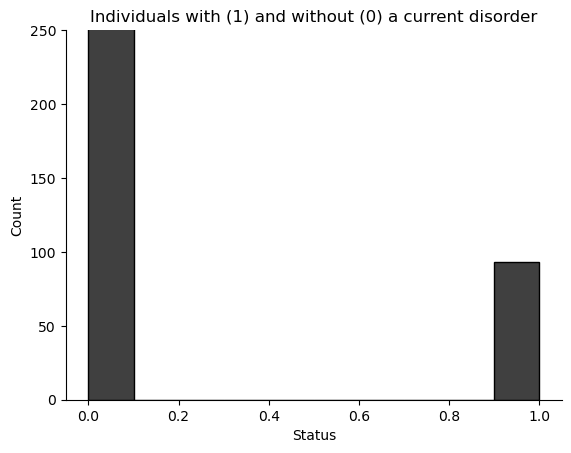

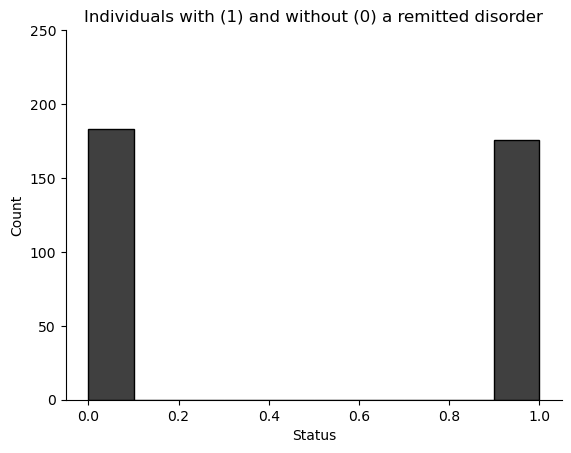

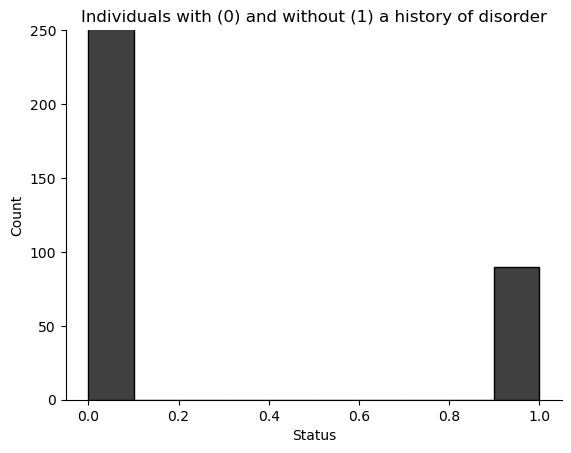

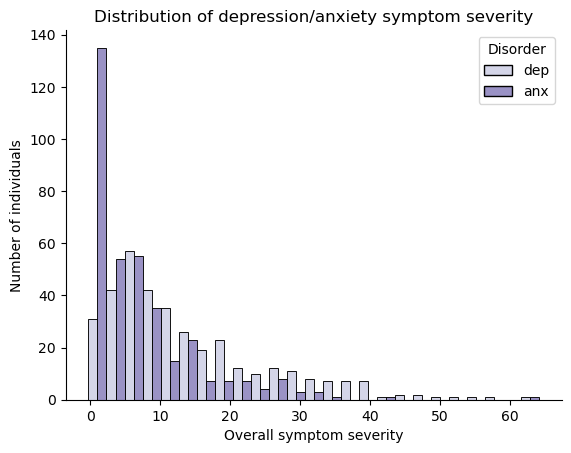

In [14]:
make_histograms()

### 2. Different sources of variation

#### Explanation

With experience sampling and actigraphy, we have measured multiple individuals multiple times. This means we can (if we want to) work with two sources of variation: within-person and between-person. 

- Within-person variation refers to changes in a variable within a person over time. For instance, over the course of two weeks, my physical activity level changes from moment to moment and so does my affective state (i.e., at one time-point I feel more stressed than at another time-point). This variation is called within-person variation and we have such variation in our actigraphy and experience sampling data. 
- Between-subject variation refers to variation in stable differences between individuals. For instance, people differ in their average sleep duration, with some people sleeping very little and other people sleeping very much, on average. Or, individuals differ in their level of depression and anxiety symptoms; some people have very little, others have medium symptoms, others have severe symptoms. The overall variation in such stable factors is referred to as between-person variation and this variation is present in all our datasets.

#### Code

In [ ]:
import numpy as np

def make_time_variable(df):
    df['Time'] = np.arange(df.shape[0])
    return df

def make_within_between_plot(df):    
    
    df = df.groupby('id').apply(make_time_variable).reset_index(drop = True)

    print('Here is what the original data looks like for a couple of people')
    
    plot = sns.lineplot(data = df.iloc[:400], x = 'Time', y = 'Q1 I feel bad-good', hue = 'id', palette = 'Purples')
    sns.despine()
    sns.move_legend(plot, loc = 'upper right', bbox_to_anchor=(1.2,1))
    plt.ylim(-5,8)
    plt.title('Time-series plots for the affective valence in multiple individuals')
    plt.show()

    print('\n')
    
    df = df[df['Q1 I feel bad-good'] > 0]

    print('And here it is when we take each person average and plot their distribution as a histogram')
    
    plot = sns.histplot(df.groupby('id').aggregate({'Q1 I feel bad-good':'mean'}), palette = 'Purples')
    sns.despine()
    sns.move_legend(plot, loc = 'upper right', bbox_to_anchor=(1.4,1))
    plt.xlim(1,7)
    plt.xlabel('Average response to the item Q1 I feel bad-good')
    plt.title('Distribution of how bad/good people feel on average')
    plt.show()

    print('\n')
    
    print('What is the meaning of the negative values in our first plot?')

#### Visualising within-person vs between-person variation
Let's say we have used experience sampling to measure how individuals feel multiple times a day for a period of two weeks, on a self-report scale that ranges from 'I feel bad' (1) to 'I feel good' (7). We have done this in a group of 300 individuals, 150 of which have a depression/anxiety disorder and 150 do not have a disorder. 

We could try to take these 'feeling bad/good' measures and see if we can use those measures to distinguish between individuals with and without a disorder. This means we are trying to connect within-person variation to between-person variation. What would be a good way of doing that? Could we simply use the raw 'feeling bad/good' scores or might it be helpful to first transform these scores or could we maybe do either of these?

Below we have made two plots to illustrate the difference between within- and between-person variance. The first plot contains the original time-series of 'feeling bad/good' in a couple of individuals and here you can see that people's feelings change over time (within-person variation). Sometimes they feel good, sometimes they feel bad. Another plot with the average of these time-series, plotted as a histogram. Every observation represented in this histogram is one data point that summarizes the time-series of each individual. Here you can see that people have different average levels of feeling bad/good (between-subject variation). 

Here is what the original data looks like for a couple of people


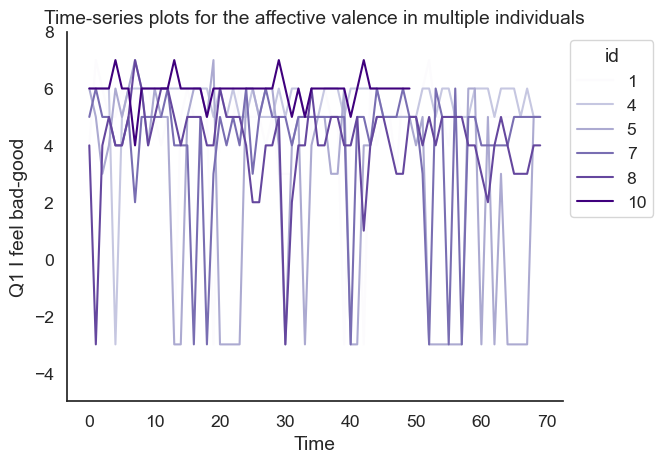



And here it is when we take each person average and plot their distribution as a histogram


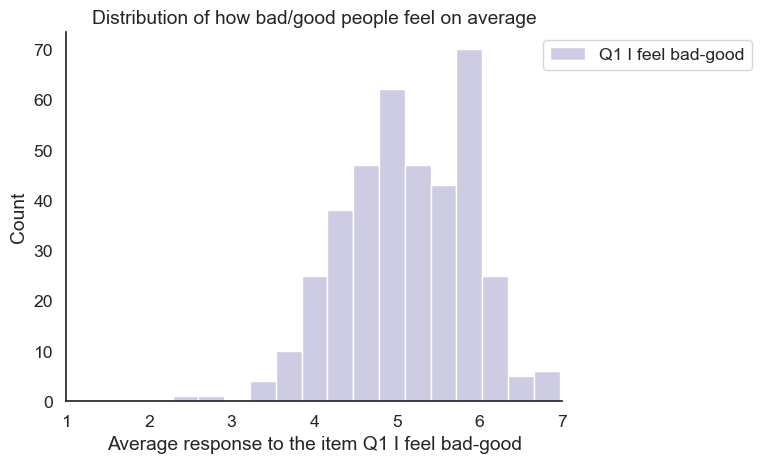



What is the meaning of the negative values in our first plot?


In [125]:
make_within_between_plot(df2)

### 3. Different sampling frequencies

#### Explanation

An interesting property of the different datasets is that they are not sampled at the same frequency. The diagnostic and disorder severity data are only sampled once for each person (and as a result we have only between-person variance on these measures), the experience sampling data 5 times a day, and the actigraphy data 30 times per second (but we have reduced this sampling rate to one per minute). This is a challenge for when we want to combine these datasets into a single analysis. 

In the previous plots, you already saw one potential (but not the only thinkable) way to deal with this issue to make the experience sampling data compatible with the diagnostic/severity data. Could we do something like this for combining the actigraphy and experience sampling data? 

Let's have a look at what these data look like when we plot their raw state on top of each other (plot is below the code for generating these plots)...

#### Code

In [6]:
def select_data_single_subject(df1, df2, df3, df4, pp_id):
    return df1[df1.id == pp_id], df2[df2.id == pp_id], df3[df3.id == pp_id], df4[df4.id == pp_id]

def make_time_series_plot_single_subject(df1, df2, df3, df4, esm_variable, pp_id):

    # First select actigraphy and experience sampling data for one subject
    df1, df2, df3, df4 = select_data_single_subject(df1, df2, df3, df4, pp_id)

    # Then make this individual's timestamps datetime objects and give them a common name
    df1.loc[:,'timestamp'] = pd.to_datetime(df1.timestamp)
    df2.loc[:,'Time of day participant completed the questionnaire'] = pd.to_datetime(df2['Time of day participant completed the questionnaire'])
    df2 = df2.rename({'Time of day participant completed the questionnaire':'timestamp'}, axis = 1)
    df2.loc[:,'timestamp'] = pd.to_datetime(df2.timestamp)

    # Scale variables by the max value to make them more comparable
    df1.loc[:,'ENMO'] = df1.ENMO/df1.ENMO.max()
    df2.loc[:,esm_variable] = df2[esm_variable]/df2[esm_variable].max()

    # Plot the two time-series on top of each other
    sns.set(font_scale = 1.15, font = 'Arial', style = 'white')
    plt.figure(figsize=(20,5))
    sns.lineplot(data = df1, x = 'timestamp', y = 'ENMO', color = 'black')
    sns.scatterplot(data = df2, x = 'timestamp', y = esm_variable, color = 'red')
    sns.despine()
    plt.xlabel('Time')
    plt.ylabel('Values (max-scaled)')
    plt.title('Single-subject time-series plot for participant #' + str(pp_id) + ' of actigraphy (one observation per minute) with ' + esm_variable + ' (at most five observations per day)')
    plt.show()

def make_example_time_series_plot():
    
    df1, df2, df3, df4 = read_data()
    
    make_time_series_plot_single_subject(df1, df2, df3, df4, esm_variable = 'Q1 I feel bad-good', pp_id = 1)

#### Visualization

As the example plot below shows, the experience sampling data is measured much less frequently than the actigraphy data. And imagine that, for each of these data sources, we only have one (!) measurement occasion of mental illness per person. What are the different approaches to bringing these variables with different sampling frequencies together? What are the pros and cons of these approaches?

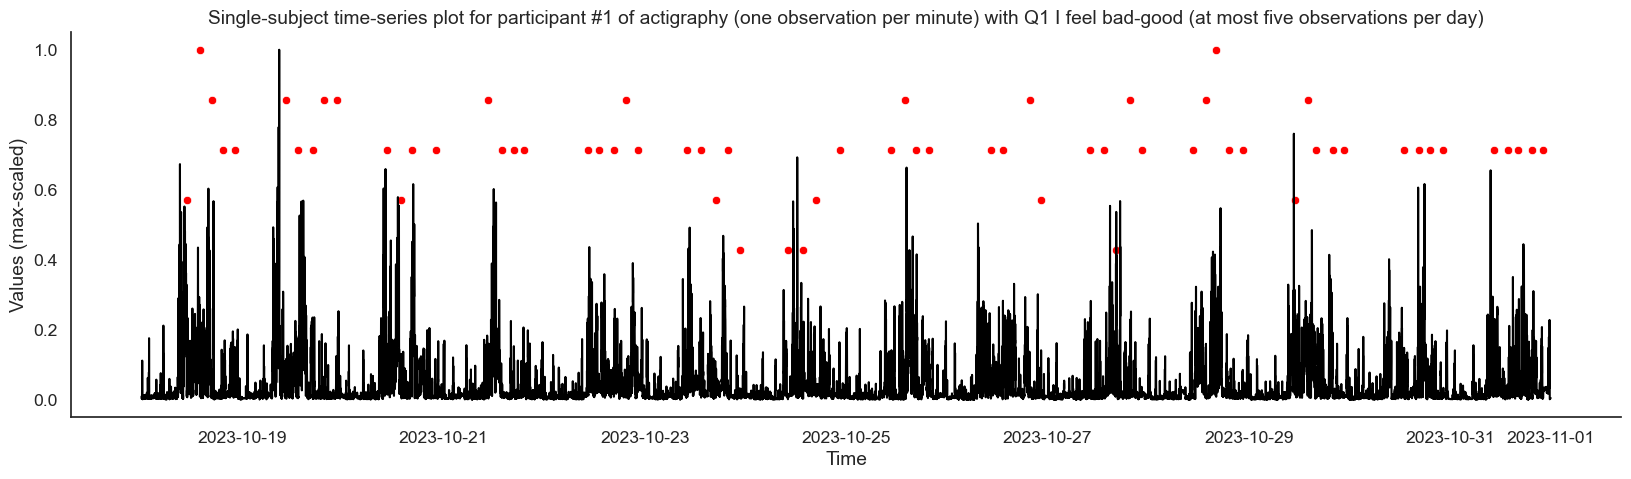

In [7]:
make_example_time_series_plot()

There are different ways of dealing with these different sampling frequencies:

- <b>USE THE RAW DATA</b>: You could just try to connect these data sources as they are. So you could, for instance, try to use the raw actigraphy data and connect it to the raw self-reports of 'I feel bad/good'; for instance, you could try to predict whether a person feels bad based on their raw actigraphy data in the past hour. That might be worth an experiment for the people who are a bit more advanced and have deep learning or anomaly detection experience! We were thinking that you could go for long-short term memory, dynamic time warping, detrended fluctuation analysis... or maybe you've got other interesting ideas. 

- <b>DO FEATURE EXTRACTION</b>: Another option is to bring the fastest data source down to the tempo of the slowest data source. So, for each response of to the item 'I feel good', we might want to summarize the actigraphy data that preceded it (or followed it, depending on what you find interesting) by computing some statistics of the actigraphy data. We could, for instance, try to compute the average activity level in the hour before the self-report. We think you can use your domain expertise or maybe automated feature extraction methods for this.

### 4. Different sources of information

We have presented different datasets, some of which have multiple variables that contain information about different aspects of a person's life. It might be possible that the combination of these variables contains information above and beyond the individual variables. Consider these examples and use your domain knowledge:

- The experience sampling dataset contains information about a person's context as well as how they feel right now. Is it possible that we can recognize a mental disorder based on how a person responds to their context?
- If we combine the actigraphy data with the experience sampling data, we could determine how much a person moved in the past hour or slept the previous night and combine that information with how they feel right now. Could the combination of those two information sources tell us something about a person's mental health?

The answer to at least the first example should be: yes, to some extent. For instance, if an individual feels extremely anxious in the presence of other humans, this would be considered symptom of social anxiety disorder. In other words, the combination of these variables is diagnostically relevant. But how do we figure these combinatios out with our data? We have more than a few variables so there is quite a combinatorial explosion when we try to figure out which ones work well together. 

How should we use AI to figure out which combinations of variables are (a bit) informative? 

Note: We actually really do not know because we have not had the time to have a proper look at this, so if you are interested, you would help us a great deal by making a start with this and showing us your preliminary results on Friday. 

# VU AI Winter School: Examples with (limited) code

Here are some general use cases for an AI technology developed using the data we share with you (the specific implementation etc is up to you):

- <i>disorder recognition</i>: build a model that uses actigraphy and/or experience sampling to recognize whether a person has a depression/anxiety disorder

- <i>disorder severity estimation</i>: build a model that uses actigraphy and/or experience sampling to estimate how severe a person's depression/anxiety symptoms are
  
- <i>well-being recognition/forecast</i>: build a model that uses actigraphy and/or experience sampling to estimate if a person feels worse than usual today or will feel worse than usual tomorrow
  
- <i>well-being optimization</i>: build a recommendation system that uses actigraphy and/or experience sampling data to recommend what a person can do to feel better

Each of these use cases can be approached differently. For instance, you could do disorder recognition by using all the data to make predictions. But you could also do such a project with the aim of minimizing experience sampling survey length. Or you could argue experience sampling is not a feasible methodology for this task and you would rather focus on actigraphy. And then within actigraphy, there are different approaches you could follow.

### Beginner: Disorder recognition from actigraphy data

In [3]:
# Let's start by loading the data 
df1, df2, df3, df4 = read_data()

# Because the actigraphy data (df1) has many rows, we select a part of the data so it does not take ages and ages to run our 
# developmental code... We select the first 100k rows because we then have multiple participants to work with. Print the data 
# so you can see what we're working with. 
print('This is what the actigraphy data looks like')
print(df1.iloc[:100000,:])
print('\n')

# A nice trick with pandas is to combine .groupby() with a function, such as .mean(). This allows you to compute the mean of a 
# variable/feature for multiple individuals at once. Without any for loops. Have a look at the code below. With only one line, 
# we here compute the average ENMO (physical activity) value for each individual. Nice.
print('This is what the actigraphy data looks like when aggregated per person')
print(df1.iloc[:100000,:].groupby('id').ENMO.mean())
print('\n')

# Let's keep it simple for now and compute the average activity for each individuals and save the resulting values in a new df 
# (in case you don't know, df stands for dataframe and I will now use that abbreviation throughout the code). In this case, we 
# will call our new df X. This is not to confuse you but because we want to distinguish between features (X) and targets (y). I
# think this will make sense when we progress but let me know if not. 

# Okay, so we use the following code to compute the average activity level for each person and we save the result in X. It is 
# actually a lot quicker on the whole data than I thought. But keep in mind that it's most efficient to develop your code on a 
# part of the data. 
X = df1.groupby('id').ENMO.mean().reset_index()

# Actually, let's be a bit more ambitious and also calculate the standard deviation of activity.
X = df1.groupby('id').agg({'ENMO':['mean','std']}).reset_index()
X.columns = X.columns.map('_'.join).str.strip('_')

# So now we have our features - the average and standard deviation of ENMO. What can we do with that? Well, maybe, we can already 
# use that information to distinguish between people with and without a current disorder. Let's have look...

# Perhaps confusingly, I have saved the diagnostic data in an object called df4. Let's see what's in there...
print('This is what the diagnostic data looks like')
print(df4)
print('\n')

# Okay, so we have four columns here. We need two of those: id and current. Let's select them and save them in y.
y = df4[['id','current']]

# Are the X and y compatible? Let's find out by printing their shape.
print('Here is the shape of the features and targets. Are you can see, they are not of equal size') 
print(X.shape)
print(y.shape)
print('\n')

# Argh, we have more individuals with features than with labels... :-( 
# Let's do an inner merge which is a method of merging the data that retains only rows where we have actigraphy and diagnosis.
df = pd.merge(X, y, on = 'id')

# Now we can split the data back to X and y. We drop the id column 
X = df.drop(['id','current'], axis = 1)
y = df.current

# Great, now we've got our Xs and ys and we can already do our first MACHINE LEARNING attempt. We will do it WRONG at first.

# Let's import scikit-learn (sklearn) which is the Python library for machine learning 
import sklearn

# Now, I will disappoint some of you by starting with something that does not sound like ML at all: logistic regression.
from sklearn.linear_model import LogisticRegression

# Here's what we do: we first build some functions to do the machine learning for us and then we run the functions. It can 
# be helpful to make your code modular like this, because it makes it (a bit) easier to handle more complex projects. 
def build_model(model_type):
    if model_type == 'lr':
        model = LogisticRegression()
    else:
        pass
    return model

def fit_model(X, y, model):
    return model.fit(X, y)

def predict_model(X, model):
    return model.predict(X)

# We first build a model. It is a dumb model that can't do nothing yet
model = build_model('lr')

# We then fit the model. This is probably still a relatively dumb model but it can do something
model = fit_model(X, y, model)

# And that something it can do, is called predicting (in our case, recognizing might be a better word, though). 
# This means: the model more or less looks at some actigraphy data to decide (and tell us) if a person has a disorder or not.
y_pred = predict_model(X, model)

# You might think: so what, is the model doing any good? Okay, good question. 
# Let's put the model predictions in a dataframe with the actual labels...
df = pd.concat([y, pd.Series(y_pred)], axis = 1)

# We will refer to the actual labels as y_true and the predicted labels as y_pred
df.columns = ['y_true', 'y_pred']

# Well, printing this stuff does not really show you a lot... maybe we need a metric?
from sklearn.metrics import accuracy_score

# We have a model that is 74.1% accurate. That sounds decent, right?
print('Here is the accuracy of our first machine learning model, using only actigraphy features')
print(accuracy_score(df.y_true, df.y_pred))
print('\n')

# Well, what's decent? It should at least do better than a really dumb model (majority class prediction model) 
# that always says a person has no disorder.
import numpy as np
print('And although that might sound alright, this is not better than our majority class prediction model')
print(accuracy_score(df.y_true, np.repeat(0, df.shape[0])))
print('\n')

# Maybe if we try something easier... What if we try some experience sampling data? Can we detect disorder based 
# on how people generally feel?
X = df2.groupby('id').agg({'Q1 I feel bad-good':'median', 'Q7 I feel irritated':'median'}).reset_index()
y = df4[['id','current']]

df = pd.merge(X, y, on = 'id')

X = df[['Q1 I feel bad-good', 'Q7 I feel irritated']]
y = df.current

model = build_model('lr')
model = fit_model(X, y, model)
y_pred = predict_model(X, model)
df = pd.concat([y, pd.Series(y_pred)], axis = 1)
df.columns = ['y_true', 'y_pred']

# Alright, we're doing a little bit better now. But we have not actually tested our model. We have only fitted the model. 
print('Here is the accuracy of our experience sampling model, on the entire dataset')
print(accuracy_score(df.y_true, df.y_pred))
print('\n')

print('It is a bit better than our majority class model')
print(accuracy_score(df.y_true, np.repeat(0, df.shape[0])))
print('\n')

# But for now we will stick with our simple logistic regression. Does the model predict well? 
from sklearn.model_selection import train_test_split

# We do something called a train-test split, separating data into a partition for fitting the model and 
# a partition for evaluating the model.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# We reset our model and build a new empty logistic regression model.
model = build_model('lr')

# We then fit the model on the TRAIN data (X_train, y_train)
model = fit_model(X_train, y_train, model)

# We then evaluate the model on the TEST data (X_test, y_test)
def evaluate_model(X_test, y_test, model):

    y_pred = predict_model(X_test, model)   

    df = pd.concat([y_test.reset_index(drop = True), pd.Series(y_pred).reset_index(drop = True)], axis = 1)

    df.columns = ['y_true','y_pred']

    return accuracy_score(df.y_true, df.y_pred)

print('Here is the accuracy of our experience sampling model, on the train data')
print(evaluate_model(X_train, y_train, model))
print('\n')

print('Again, it is a bit better than our majority class model')
print(accuracy_score(y_train, np.repeat(0, y_train.shape[0])))
print('\n')

print('But then here is the accuracy of our experience sampling model on the test data')
print(evaluate_model(X_test, y_test, model))
print('\n')

print('And it is actually worse than our majority class model')
print(accuracy_score(y_test, np.repeat(0, y_test.shape[0])))
print('\n')

print("Can you develop a model that performs better on test data?")

This is what the actigraphy data looks like
       id                  timestamp    ENMO  nonwearscore  clippingscore
0       1  2023-10-18 00:00:00+00:00  0.0257             0            0.0
1       1  2023-10-18 00:01:00+00:00  0.0214             0            0.0
2       1  2023-10-18 00:02:00+00:00  0.0244             0            0.0
3       1  2023-10-18 00:03:00+00:00  0.0729             0            0.0
4       1  2023-10-18 00:04:00+00:00  0.0479             0            0.0
...    ..                        ...     ...           ...            ...
99995   8  2025-05-08 10:35:00+00:00  0.4964             0            0.0
99996   8  2025-05-08 10:36:00+00:00  0.5621             0            0.0
99997   8  2025-05-08 10:37:00+00:00  0.2128             0            0.0
99998   8  2025-05-08 10:38:00+00:00  0.0879             0            0.0
99999   8  2025-05-08 10:39:00+00:00  0.0663             0            0.0

[100000 rows x 5 columns]


This is what the actigraphy data looks 

In [19]:
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import balanced_accuracy_score

def make_data():
    '''
    Here you can write a function that returns X_train, X_test, y_train, y_test.
    You could, for instance, work with arguments that specify which variables &
    statistical properties of those variables you are interested in working with. 
    '''
    pass 
    #return X_train, X_test, y_train, y_test

def build_model(model_type):
    '''
    Here you can experiment with different model types and hyperparameter values. 
    Have a look at the scikit-learn documentation to see which hyperparameters go
    with which models. Then, include your hyperparameters in "params" dictionaries
    as well as some values for them. Then explore how different values change your 
    model's performance on train and test data.
    '''
    if model_type == 'lr':
        model = LogisticRegression()
        params = {} # Here we just use LogisticRegression() without further parameters
                    # but for the other models, you can specify hyperparameters. We've
                    # already made a start for some of those, as you can see below ...
        
    elif model_type == 'elasticnet':
        
        model = LogisticRegression()
        params = {'penalty':['elasticnet'],               
                  'C':np.arange(0.01,1,0.01),
                  'l1_ratio':np.arange(0.1,1,0.1),
                  'solver':['saga']}
        
    elif model_type == 'svm':
        
        model = SVC()
        params = {'C':np.arange(0.01,1,0.01),
                  'gamma':np.arange(0.01,1,0.01),
                  'kernel':['rbf']}
        
    elif model_type == 'rf':
        
        model = RandomForestClassifier()
        params = {'max_depth':[1,2,3,4,5],
                 'n_estimators':[100,200,300,400,500]}
        
    return RandomizedSearchCV(model, params, cv = 10)

def fit_model(X, y, model):
    return model.fit(X, y)

def predict_model(X, model):
    return model.predict(X)

def evaluate_model(X_test, y_test, model, evaluation_metric):
    '''
    Here you can experiment with different evaluation metrics. Look at the scikit-learn metrics 
    documentation to see the available metrics and choose metrics that seem appropriate for your 
    specific problem or that are commonly used in your domain (eg, AUC-ROC, etc.). Make sure you 
    evaluate whether your model performs any better than a baseline model. This could be the most 
    simplistic model out there (ie majority class prediction model) or a model based on cheaper or
    less invasive data (eg depression survey vs experience sampling).
    '''
    y_pred = predict_model(X_test, model)   

    df = pd.concat([y_test.reset_index(drop = True), pd.Series(y_pred).reset_index(drop = True)], axis = 1)

    df.columns = ['y_true','y_pred']

    if evaluation_metric == 'accuracy':
        return accuracy_score(df.y_true, df.y_pred)
    elif evaluation_metric == 'balanced_accuracy':
        return balanced_accuracy_score(df.y_true, df.y_pred)
    else:
        pass

#X_train, X_test, y_train, y_test = make_data()

# Build a model type
model = build_model('rf')

# Fit the model on train data
model = fit_model(X_train, y_train, model)

# Evaluate how well the model performs on your train data
print(evaluate_model(X_train, y_train, model, evaluation_metric = 'balanced_accuracy'))

# Then have a look at how it performs on your test data
print(evaluate_model(X_test, y_test, model, evaluation_metric = 'balanced_accuracy'))

0.6857047224926972
0.5110837438423645


### Intermediate: Daily fatigue recognition with actigraphy data

In [6]:
def make_data(df1, df2):
    '''
    This function turns the actigraphy data from long format into wide format, computes a daily fatigue score, 
    and merges the former with the latter. Returns the minute-by-minute actigraphy as X and daily fatigue as y.
    '''
   
    df1['timestamp'] = pd.to_datetime(df1.timestamp)
    df1['date'] = df1.timestamp.dt.date
    df1['time'] = df1.timestamp.dt.time
    df_activity = df1.pivot(index = ['id','date'], columns = 'time', values = 'ENMO')
    
    df2['timestamp'] = pd.to_datetime(df2['Time of day sms/text was sent'])
    df2['date'] = df2.timestamp.dt.date
    df_fatigue = df2.groupby(['id', 'date']).agg({'Q19 I feel tired':'median'})
    
    df = pd.merge(df_activity, df_fatigue, on = ['id', 'date'])
    
    X = df.drop('Q19 I feel tired', axis = 1)
    y = df['Q19 I feel tired']

    return X, y

df1, df2, _, _ = read_data()
X, y = make_data(df1, df2)

print('Can you train a model that uses the raw actigraphy data to estimate daily fatigue?')
print('\n')

print('Here is one example of how the raw actigraphy data might be formatted... but this could be different of course.')
print('\n')
print(X)

print('Here is one example of what the daily fatigue scores could look like... but this could be preprocessed differently.')
print('\n')
print(y)

Can you train a model that uses the raw actigraphy data to estimate daily fatigue?


Here is one example of how the raw actigraphy data might be formatted... but this could be different of course.


                00:00:00  00:01:00  00:02:00  00:03:00  00:04:00  00:05:00  \
id  date                                                                     
1   2023-10-18    0.0257    0.0214    0.0244    0.0729    0.0479    0.0406   
    2023-10-19    0.0317    0.0301    0.0304    0.0338    0.0302    0.0319   
    2023-10-20    0.0434    0.0434    0.0426    0.0445    0.0425    0.0439   
    2023-10-21    0.0349    0.0311    0.8328    1.0756    0.1489    0.2303   
    2023-10-22    0.0087    0.0170    0.0312    0.0438    0.0418    0.0384   
...                  ...       ...       ...       ...       ...       ...   
997 2032-01-23    0.0496    0.0488    0.0488    0.0668    0.0486    0.0488   
    2032-01-24    2.4382    2.7506    2.4759    2.9643    2.4868    1.3721   
    2032-01-25    0.0

### Advanced: detecting anomalies in actigraphy data to identify bad days